# Use Amazon Braket to model quantum time evolution

The purpose of this section is to teach you how to model the time evolution of a quantum system described by any Hamiltonian using quantum gates that are provided by most of the QPU’s and simulators offered by Amazon Braket. This section is designed for you to be able to easily replace the Hermitian Hamiltonian that we provide with any Hermitian Hamiltonian of your choosing and to apply these methods to a wide variety of QPU’s and simulators.

## Set up the Hamiltonian

The first step of this tutorial is to set up a random Hermitian Hamiltonian that we are going to use to describe the time evolution of our quantum system. This can be done with the following code:


In [1]:
import numpy as np

# First we define the number of qubits we are going to use.
n = 3

# This defines the Hilbert space of the Hamiltonian. Notice that the size of the Hamiltonian can only be a power of two.
nq = 2**n

# Create a random matrix with values between -1 and 1.
x = np.random.uniform(-1,1, size=(nq,nq))+1j*np.random.uniform(-1,1, size=(nq,nq))

# Use this random matrix to create a Hermitian matrix that we will use for our Hamiltonian.
h = 0.5*x+0.5*x.conj().T

*Note:* We are using a random Hamiltonian just to demonstrate the flexibility that this algorithm has to accommodate any Hermitian Hamiltonian. Feel free to replace this Hamiltonian with another Hermitian Hamiltonian of your choice.

The next step of this tutorial is to decompose this Hamiltonian into a series of Kronecker products of Pauli matrices (Pauli products) so that this problem can be more digestible to a quantum algorithm. One pleasant feature of using Kronecker products of Pauli and identity matrices is that you can decompose any matrix into a sum of these products multiplied by a constant. If we define a three dimensional matrix composed of the three Pauli matrices and a $2×2$ identity matrix as such: $σ~=(I,σ_x,σ_y,σ_z)$, then for our three qubit system, we can define our Hamiltonian as: $H=\frac{1}{N}∑_{i,j,k} h_{i,j,k} \tilde{\sigma}_i⊗\tilde{\sigma}_j⊗\tilde{\sigma}_k$. Here, $N=2n$ where $n$ is the number of qubits, the subscripts on $σ~$ determine the Pauli matrix or identity matrix of interest, and the summation takes into account all possible combinations of Pauli and identity matrices in the Kronecker product. The term $h_{i,j,k}$ is given by the equation: $h_{i,j,k}=TR(\tilde{σ}_i⊗\tilde{σ}_j⊗\tilde{σ}_k H)$. This is implemented with the following code:


In [ ]:
import math
# sigma is a matrix composed of identity and Pauli matrices
sigma = np.zeros((2,2,4), dtype=complex)
sigma[:,:,0] = np.matrix([[1, 0],[0, 1]])
sigma[:,:,1] = np.matrix([[0, 1],[1, 0]])
sigma[:,:,2] = np.matrix([[0, -1j],[1j, 0]])
sigma[:,:,3] = np.matrix([[1, 0],[0, -1]])

# basis will be used to store the Kronecker products of Pauli and identity matrices.
basis = np.zeros((nq,nq,4**n), dtype=complex)
# circind will be used to translate the Kronecker products of Pauli and indentity matrices into quantum gates.
circind = np.zeros((n,4**n), dtype=complex)

# i loops over all possible combinations of Kronecker products
for i in range(4**n):
    matrix = np.zeros((2,2,n), dtype=complex)
    # j loops over all of the qubits
    for j in range(n):
        # num and num2 are constants that determine the combination of Kronecker products of interest.
        num = math.floor(i/(4**j))
        num2 = num % 4
        circind[j,i] = num2
        # matrix is used to store the Pauli and identity matrices used for the Kronecker products of the current iteration of i.
        matrix[:,:,j] = sigma[:,:,num2]
    # matrixsmall and the subsequent iteration of j constructs the Kronecker product relevant for the current iteration of i.
    matrixsmall = matrix[:,:,-1]
    matrixfull = []
    for j in range(n-1):
        del matrixfull
        matrixfull = np.kron(matrix[:,:,-2-j],matrixsmall)
        del matrixsmall
        matrixsmall = matrixfull
    basis[:,:,i] = matrixfull
    del matrixfull
    del matrixsmall

Now that we have obtained all of the Kronecker products with which we are going to decompose our Hamiltonian, it is time to obtain the constants $h_{i,j,k}$:

In [ ]:
# const will be a vector storing all of the constants of interest
const = np.zeros(4**n, dtype=complex)
# null will be a vector that stores where all of the constants in const are zero
null = []

# i loops over all possible combinations of Kronecker products
for i in range(4**n):
    # Below multiplies the Hamiltonian by the Kronecker product of interest.
    gfg = basis[:,:,i] @ h
    # Below takes the trace of this result and stores them in const
    const[i] = gfg.trace()/nq
    if const[i]==0:
        null.append(i)
        
# Delete components of basis, const, and circind corresponding to where const is zero
if len(null)>0:
    del basis[:,:,null]
    del const[null]
    del circind[:,null]

**Note:** All of the above code pieces work for any value of the number of qubits $n$ and for any appropriately sized Hamiltonian. This code removes all instances where const equals zero (which in this case there are none) as well as the corresponding components of circind in order to save computer time.

The final step to setting up our quantum system is to set up the initial wave function:


In [ ]:
# eigensig is a matrix that stores all of the eigenvectors of the Pauli matrices.
eigensig = np.zeros((2,6), dtype=complex)
eigensig[:,0] = np.array([1, -1])
eigensig[:,1] = np.array([1, 1])
eigensig[:,2] = np.array([1, -1j])
eigensig[:,3] = np.array([1, 1j])
eigensig = (1/math.sqrt(2))*eigensig
eigensig[:,4] = np.array([0, 1])
eigensig[:,5] = np.array([1, 0])

# waveindex determines the three eigenvectors above used to construct the initial state wave function through a Kronecker product.
# The eigenvectors are chosen automatically using a random number generator and the number of these eigenvectors that go into this Kronecker product is equal to the number of qubits.
waveindex = np.random.randint(0,6,n)

# wave stores the wave function of the initial state of the quantum system.
wave = eigensig[:,waveindex[-1]]

# The bottom two lines of code uses a Kronecker product acting on the vectors stored in waveindex to create the initial wave function.
for j in range(n-1):
    wave = np.kron(eigensig[:,waveindex[-2-j]],wave)

**Note:** This code randomly chooses the states that each of the qubits are initialized in; thereby randomly choosing the initial wave function.

### Time evolution and Trotter decomposition

The time evolution of a wave function is normally done with the following equation: $∣Ψ(t)⟩=e−iHt∣Ψ(0)⟩$. Where $∣Ψ(t)⟩$ is the wave function at a time of t and H is the Hamiltonian. However, we have to remember that the decomposition of the Hamiltonian into Kronecker products of Pauli and identity matrices makes it easier to simulate this problem on a quantum computer. We also have to remember that the following inequality exists: $e^{−i(c_1 P_1 + c_2 P_2)t}\neq e^{−i c_1 P_1 t} e^{−i c_2 P_2 t}$, where $P_i$ are the Pauli products that a Hamiltonian can be decomposed into and $c_i$ are the constants that scale these Pauli products appropriately (alternatively referred to as $h_{i,j,k}$). This is unfortunate because this would make calculations much easier for us and is the reason why we use Trotter decomposition. Trotter decomposition is implemented with the following approximation: $e^{−iHt}≈(Π_k e^{−ic_k P_k t/M})^M$. Here, $M$ is the Trotter number and this approximation becomes more accurate as $M$ increases.

## Setting up the quantum circuits

Now that we have decomposed our Hamiltonian, we are going to use these methods to set up a quantum circuit. The good news is that this process involves the implementation of slight variations of a simple circuit numerous times in succession. To start with, we are going to see how the Hamiltonian defined as $H=c_k σ_z ⊗ σ_z ⊗ σ_z$ (with time evolution defined as $e^{−i c_k σ_z ⊗ σ_z ⊗ σ_z t}$) is simulated on a quantum circuit. This quantum circuit is illustrated in the diagram below:


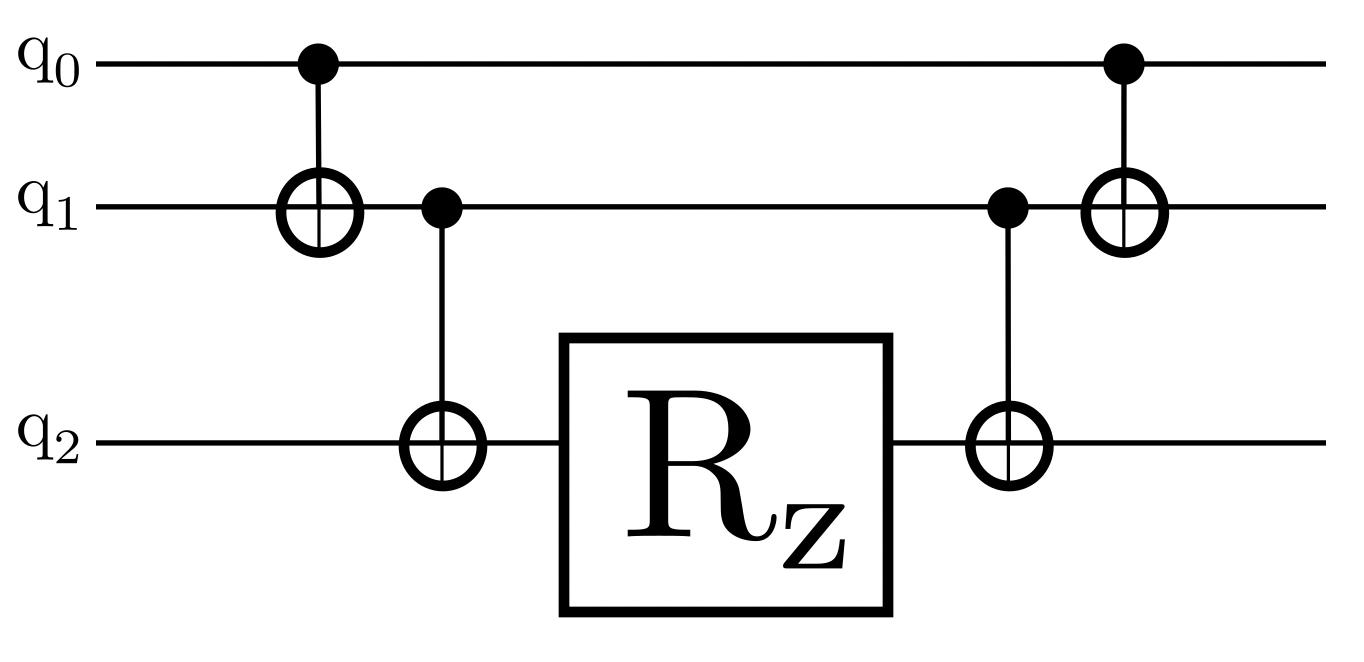

As can be seen in the diagram above, the system is initialized with three qubits: $q_0$, $q_1$, and $q_2$. Then a cnot gate is implemented (with the control qubit being the zeroth qubit and the target qubit being the first qubit) and then a second cnot gate is implemented (with the control qubit being the first qubit and the target qubit being the second qubit). After that, a rotation is implemented on the second qubit about the z-axis. The angle that the $R_z$ gate rotates the second qubit is given by: $R_z (2c_k t/M)=e^{−ic_k σ_z t/M}$, where again, $M$ is the Trotter number, $t$ is the amount of time that our quantum system is evolved for, and $c_k$ is the constant that scales $σ_z ⊗ σ_z ⊗ σ_z$ to give us our Hamiltonian (for this instance). Finally, a cnot gate is implemented with the control being the first qubit and the target being the second qubit and then another cnot gate is implemented with the control being the zeroth qubit and the target being the first qubit. 

Now we are going to see how we implement a Hamiltonian defined by a) $H=σ_y ⊗ σ_x ⊗ σ_z$ and b) $H=σ_y ⊗ σ_z ⊗ σ_x$:


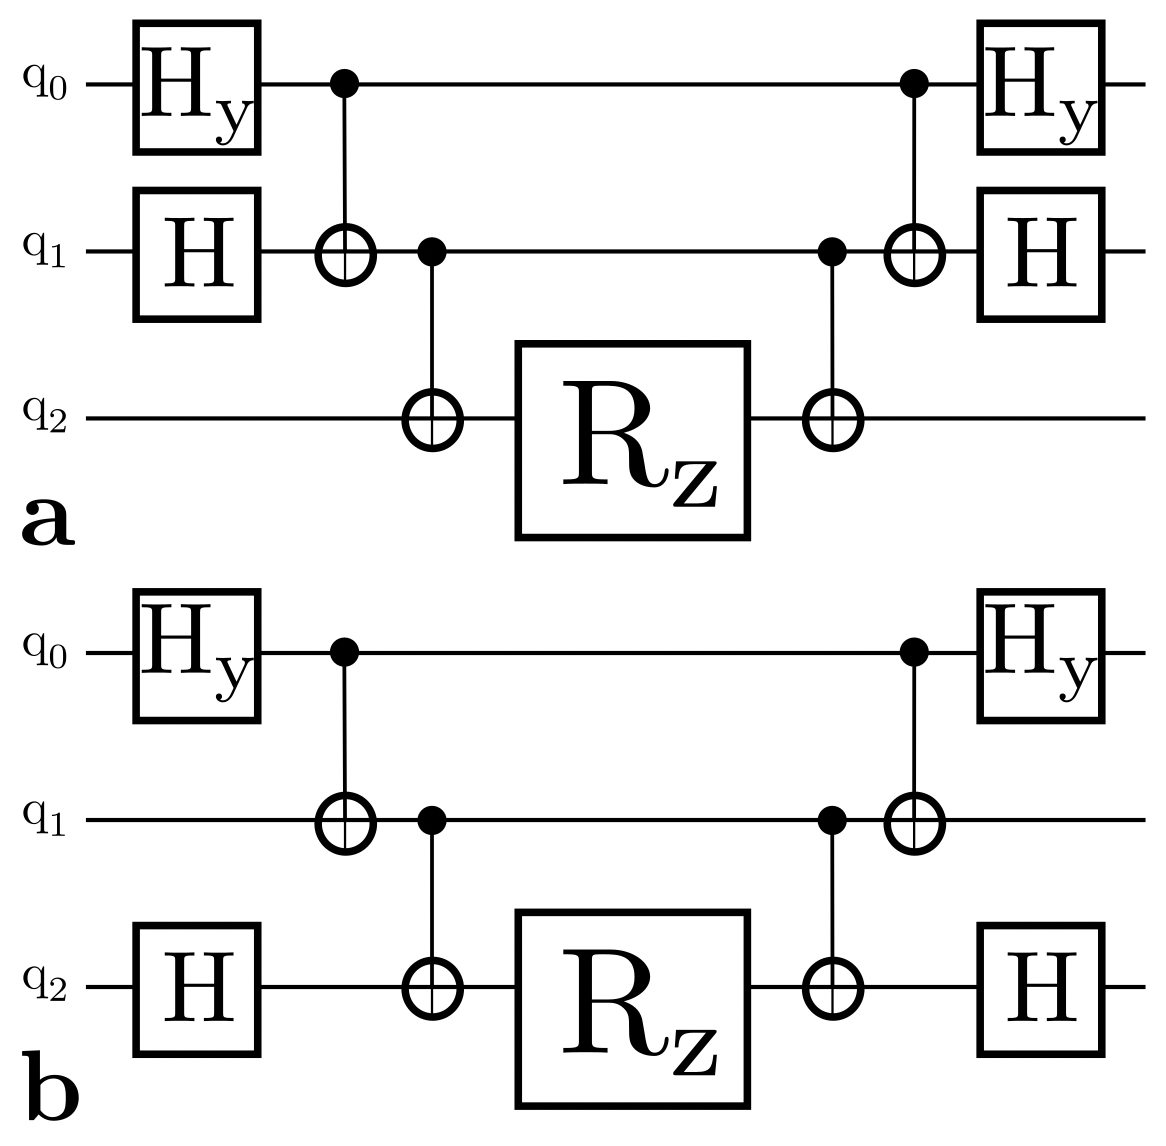

The diagram above shows that in order to turn a spin z rotation into a spin x rotation (qubit 1 in diagram a) above), you add a Hadamard gate operation to the qubit of interest at both the beginning and end of the circuit. Similarly, to turn a spin z rotation into a spin y rotation (qubit 0 in diagram a) avove), you add a self inverse gate called the $H_y$ gate to the beginning and end of the circuit. Just as a Hadamard gate can be expressed as a $\frac{π}{2}$ rotation about the y-axis followed by a z-gate, the $H_y$ gate can be expressed as a $−\frac{π}{2}$ rotation about the x-axis followed by a z-gate.

One important additional piece of information that we need for building these quantum circuits is to consider what happens when an identity operator acts on a qubit. As seen in the diagram below, the incorporation of an identity operator into the circuit is a pleasant and simple process that only involves removing all gates from acting on the qubit where the identity gate should be acting. In the diagram below, a) corresponds to the Hamiltonian $H=σ_y ⊗ I ⊗ σ_z$ and b) corresponds to the Hamiltonian $H=σ_y ⊗ σ_x ⊗ I$.


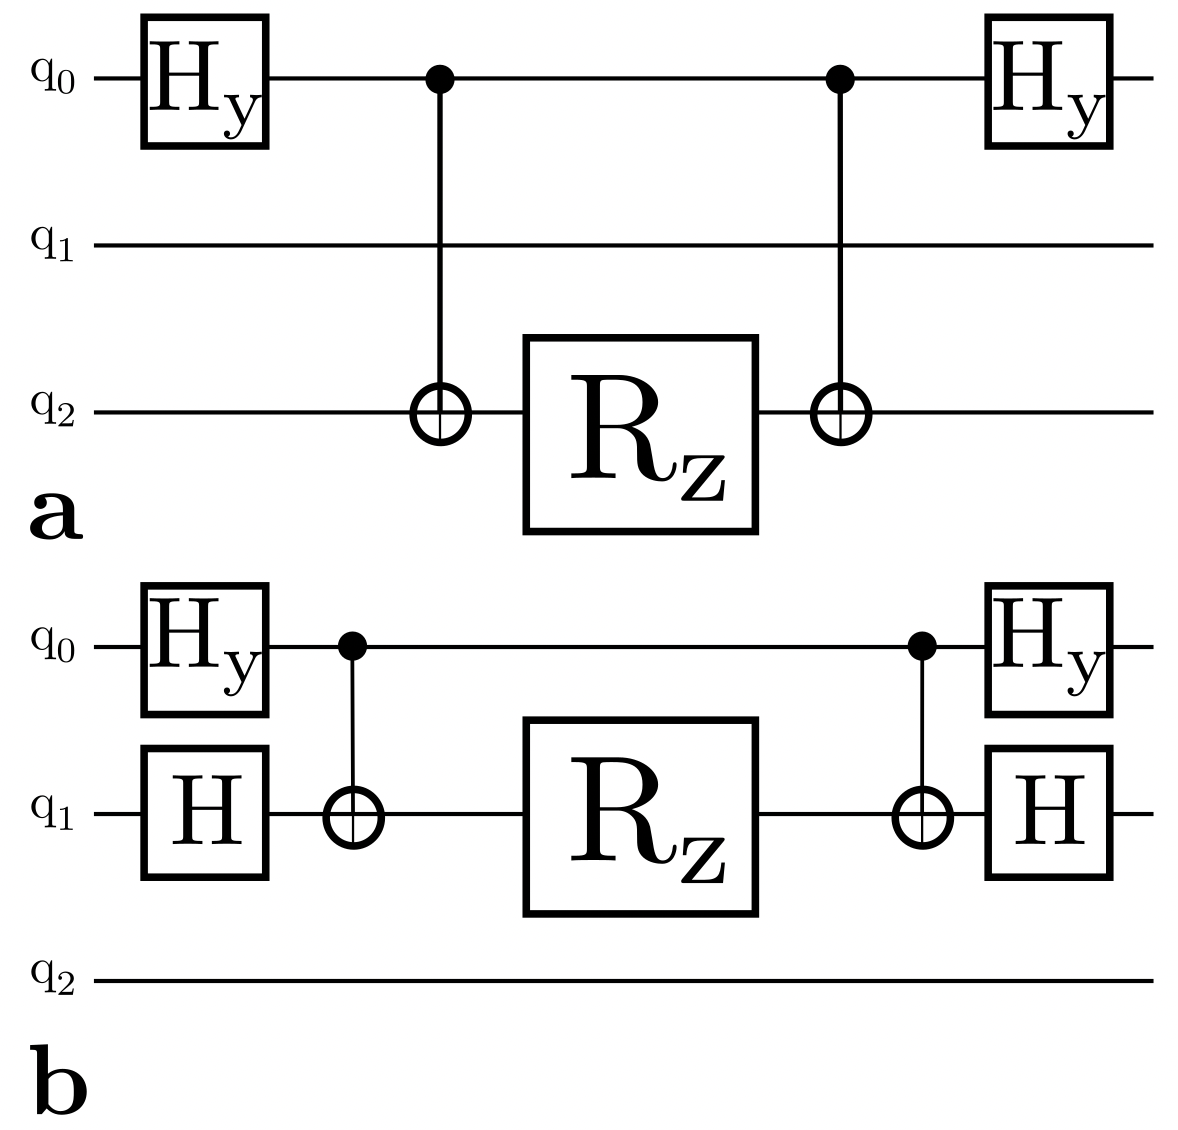

Now that we understand how to write down Hamiltonians in terms of quantum circuits, all we need to do is implement all of the Pauli products relevant to the Hamiltonian that we want to model and repeat the resulting quantum circuits $M$ (Trotter number) number of times. This can be implemented through the following code: 

In [ ]:
from braket.circuits import Circuit, Gate, Observable
# Define pi
pi = math.pi
# Initiate the quantum circuit
circ = Circuit()
# Set the Trotter number equal to 1000
m = 1000
# Set the amount of time you wish to evolve your Hamiltonian
t = 10

# The loop below initiates the qubits depending on the relevant eigenvector of the Pauli matrices used in the Kronecker product that produces the wave funtion.
# For the local simulator, the qubits are initiated in the +z direction
for i in range(n):
    check = (eigensig[:,waveindex[i]] == eigensig[:,4])
    if check[0] and check[1]:
        circ.ry(i, pi)
    check = (eigensig[:,waveindex[i]] == eigensig[:,0])
    if check[0] and check[1]:
        circ.ry(i, -pi/2)
    check = (eigensig[:,waveindex[i]] == eigensig[:,1])
    if check[0] and check[1]:
        circ.ry(i, pi/2)
    check = (eigensig[:,waveindex[i]] == eigensig[:,2])
    if check[0] and check[1]:
        circ.rx(i, pi/2)
    check = (eigensig[:,waveindex[i]] == eigensig[:,3])
    if check[0] and check[1]:
        circ.rx(i, -pi/2)
        
# The following loop with index k repeats the same circuit setup m times in order to implement Trotter decomposition.
for k in range(m):
    # i loops over all the constants that scale the Pauli products to create the Hamiltonian.
    for i in range(len(const)):
        # circind and ref1 define what axis the qubit is rotated for the Pauli product of interest or whether an identity operator acts on the qubit.
        ref1 = circind[:,i]
        # ref2 will index which qubits are rotated about an axis (as opposed to being acted on by an identity operator) to determine how the cnot gates are constructed.
        ref2 = range(n)
        index = []
        # The loop below finds all instances where an identity operator acts on a qubit.
        for j in range(len(ref2)):
            if ref1[j]==0:
                index.append(j)
        # Now remove all indices in ref2 that correspond to qubits that have identity operators acting on them.
        ref2 = np.delete(ref2, index)
        # The following loop is to implement the starting set of Hadamard and H_y gates on the appropriate qubits.
        for j in range(len(ref1)):
            if ref1[j]==1:
                circ.h(j)
            if ref1[j]==2:
                circ.rx(j,pi/2)
                circ.z(j)
        # The following if statement and for loop nested inside places the starting set of cnot gates in the appropriate places.
        if len(ref2)>1:
            for j in range(len(ref2)-1):
                circ.cnot(ref2[j],ref2[j+1])
        # The arguments within the following if statement performs an R_z rotation with the appropriate angle
        if len(ref2)>0:
            circ.rz(ref2[-1],2*const[i]*t/m)
        # The following if statement with a for loop nested inside places the ending cnot gates in the appropriate locations.
        if len(ref2)>1:
            for j in range(len(ref2)-1):
                circ.cnot(ref2[-2-j],ref2[-1-j])
        # The following for loop with the nested if statements inside places the final Hadamard and H_y gates in the appropriate locations
        for j in range(len(ref1)):
            if ref1[j]==1:
                circ.h(j)
            if ref1[j]==2:
                circ.rx(j,pi/2)
                circ.z(j)
        del ref1
        del ref2
        del index
        
# The following statement sets the observable to being the state vector.
circ.state_vector()

**Note:** The state vector result type is only available with the local simulator. If you decide to use another QPU or simulator, then you will have to choose another set of observables.

Next we submit this task:

In [ ]:
# import the LocalSimulator module
from braket.devices import LocalSimulator

# Designate the device being used as the local simulator
# Feel free to use another device
device = LocalSimulator()

# Submit the task
my_task = device.run(circ, shots=0)

# Retrieve the result
result = my_task.result()

**Note:** This simulation was performed with a ml.m5.4xlarge instance.

Now you can see how this compares with a classical simulation:


In [ ]:
from scipy.linalg import expm

# Calculate the time evolution of your quantum system classically
wave2 = expm(-1j*h*t) @ wave

# Obtain the inner product between the classical solution and the quantum solution
Inner = result.values[0].conj().T @ wave2
print(Inner)

The piece of code above calculates $⟨Ψ_Q∣Ψ_C⟩$, where $∣Ψ_Q⟩$ is the quantum solution and $∣Ψ_C⟩$ is the classical solution. This is a good indicator of the accuracy of the quantum solution and you should expect a value of around $0.9709372118770938−0.2387281938601447i$, although this can vary a lot. This has an absolute value of $0.999855099477615$, which should remain at roughly the same value for all calculations using this exact setup.

**Note:** You can expect this calculation to increase in accuracy as you increase the Trotter number and to decrease in accuracy as you increase the time.

# References

[1] https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/Hamiltonian_simulation.ipynb

[2] J.D. Whitfield, J. Biamonte and A. Aspuru-Guzik, Molecular Physics, "Simulation of electronic structure Hamiltonians using quantum computers" (2011)

[3] Seth Lloyd, Science, "Universal Quantum Simulators" (1996)

[4] M.A. Nielsen, I.L. Chuang, Cambridge University Press New York, "Quantum Computation and Quantum Information: 10th Anniversary Edition 10th" (2011)

[5] https://quantumcomputing.stackexchange.com/questions/8725/can-arbitrary-matrices-be-decomposed-using-the-pauli-basis